## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Chargement des données

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

## Nettoyage

In [3]:
to_drop = train.columns[train.isnull().mean() > 0.8]
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train[['GarageYrBlt', 'MasVnrArea']] = train[['GarageYrBlt', 'MasVnrArea']].fillna(0)

cols_fill_none = [
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'MasVnrType'
]
train[cols_fill_none] = train[cols_fill_none].fillna("None")
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

assert train.isnull().sum().sum() == 0, "Il reste des NaN dans train"


## Préparation des variables

In [4]:
X = train.drop(['Id', 'SalePrice'], axis=1).copy()
y = np.log1p(train['SalePrice'])

print("X :", X.shape)
print("y :", y.shape)


X : (1460, 75)
y : (1460,)


## Encodage catégoriel

In [5]:
qual_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
lotshape_map = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
landslope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
functional_map = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
bsmt_exposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmt_fin_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}


for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'FireplaceQu',
            'GarageQual', 'GarageCond']:
    if col in X.columns:
        X[col] = X[col].map(qual_map)

X['LotShape'] = X['LotShape'].map(lotshape_map)
X['LandSlope'] = X['LandSlope'].map(landslope_map)
X['Functional'] = X['Functional'].map(functional_map)
X['BsmtExposure'] = X['BsmtExposure'].map(bsmt_exposure_map)
X['BsmtFinType1'] = X['BsmtFinType1'].map(bsmt_fin_map)
X['BsmtFinType2'] = X['BsmtFinType2'].map(bsmt_fin_map)

## Encodage one-hot

In [6]:
X = pd.get_dummies(X, drop_first=True)
print(f"X final shape après encodage : {X.shape}")

X final shape après encodage : (1460, 197)


## fonction regression

In [ ]:
class MyLinearRegression:
    def __init__(self, lr=0.01, n_iter=2000):
        self.lr = lr
        self.n_iter = n_iter
        self.W = None
        self.b = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        self.W = np.zeros(n_features)
        self.b = 0.0

        for _ in range(self.n_iter):
            y_pred = X @ self.W + self.b

            dW = (1/n_samples) * (X.T @ (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            self.W -= self.lr * dW
            self.b -= self.lr * db

    def predict(self, X):
        X = np.array(X)
        return X @ self.W + self.b


## Séparation entraînement / validation

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train : {X_train.shape}, X_val : {X_val.shape}")

X_train : (1168, 197), X_val : (292, 197)


## Vérifications

In [8]:
assert X_train.isnull().sum().sum() == 0, "NaN détecté dans X_train"
assert (X_train.dtypes != 'object').all(), "Colonnes non numériques détectées"

## Entraînement du modèle

In [ ]:
model = MyLinearRegression(lr=0.001, n_iter=5000)  # valeurs raisonnables
model.fit(X_train, y_train.values.ravel())



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Prédictions et métriques

In [10]:
y_pred_log = model.predict(X_val)

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


RMSE : 25700.6522167738
R² : 0.9138858626705281


## Visualisation

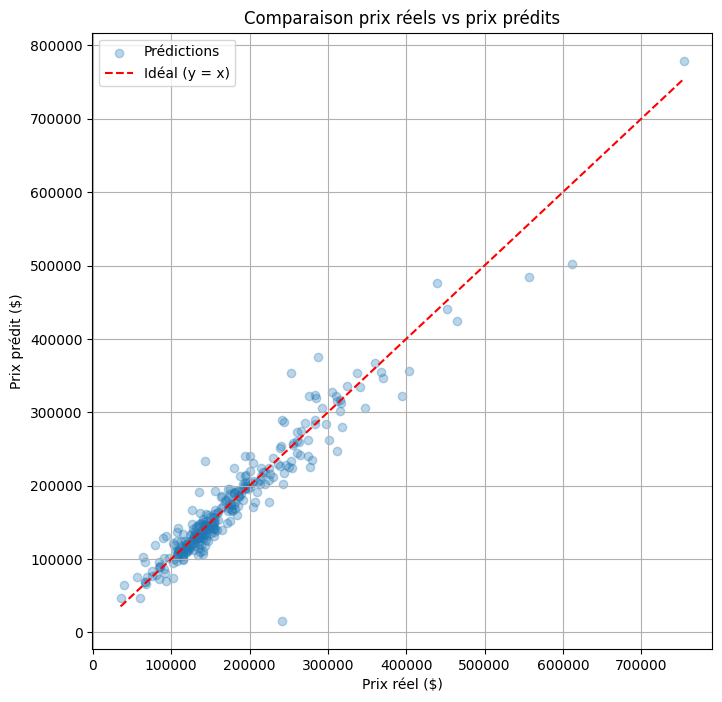

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.scatter(y_true, y_pred, alpha=0.3, label="Prédictions")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', label="Idéal (y = x)")

plt.xlabel("Prix réel ($)")
plt.ylabel("Prix prédit ($)")
plt.title("Comparaison prix réels vs prix prédits")
plt.legend()
plt.grid(True)

plt.show()


## Préparation données test

In [12]:

test.drop(columns=to_drop, inplace=True, errors='ignore')


test['LotFrontage'] = test['LotFrontage'].fillna(train['LotFrontage'].median())
test[['GarageYrBlt', 'MasVnrArea']] = test[['GarageYrBlt', 'MasVnrArea']].fillna(0)
test[cols_fill_none] = test[cols_fill_none].fillna("None")
test['Electrical'] = test['Electrical'].fillna(train['Electrical'].mode()[0])

for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'FireplaceQu',
            'GarageQual', 'GarageCond']:
    if col in test.columns:
        test[col] = test[col].map(qual_map)

test['LotShape'] = test['LotShape'].map(lotshape_map)
test['LandSlope'] = test['LandSlope'].map(landslope_map)
test['Functional'] = test['Functional'].map(functional_map)
test['BsmtExposure'] = test['BsmtExposure'].map(bsmt_exposure_map)
test['BsmtFinType1'] = test['BsmtFinType1'].map(bsmt_fin_map)
test['BsmtFinType2'] = test['BsmtFinType2'].map(bsmt_fin_map)

test_encoded = pd.get_dummies(test, drop_first=True)

test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

print("✅ Test set prêt pour la prédiction :", test_encoded.shape)

test_encoded = test_encoded.fillna(0)

print("NaN restants :", test_encoded.isnull().sum().sum())

y_test_pred_log = model.predict(test_encoded)
y_test_pred = np.expm1(y_test_pred_log)


submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_test_pred
})

submission.to_csv('../data/proced/submissionLinear.csv', index=False)


✅ Test set prêt pour la prédiction : (1459, 197)
NaN restants : 0
